# Digital inverter with OpenLane

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple digital inverter design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

In [1]:
!pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [16]:
!pip install libparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00


In [11]:
!python3 -m venv env

In [12]:
!source env/bin/activate

In [13]:
!python -m pip install -r requirements-dev.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=*
   - open_pdks.sky130a=*


  Package                                                Version  Build                 Channel        Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + open_pdks.sky130a                         1.0.456_0_g2a38e86  20231104_052339       litex-hub       1GB
  + _libgcc_mutex                                            0.1  main                  main            3kB
  + libstdcxx-ng                                          11.2.0  h1234567_1            main            6MB
  + ld_impl_linux-64                                        2.38  h1181459_1            main          749kB
  + libgcc-devel_linux-64      

## Write verilog

In [23]:
%%writefile adder.v
module half_adder(input a, b, output s, c);
  assign s = a ^ b;  // Use XOR gate for sum
  assign c = a & b;  // Use AND gate for carry
endmodule

Writing adder.v


## Write configuration

[Documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [24]:
%%writefile config.json
{
    "DESIGN_NAME": "half_adder",
    "VERILOG_FILES": "dir::adder.v",
    "RUN_CTS": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 34.5 57.12",
    "PL_TARGET_DENSITY": 0.75,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}

Overwriting config.json


## Run OpenLane Flow

[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks).

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

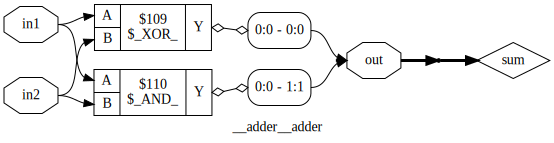

In [25]:
import graphviz
import pathlib

dot = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
graphviz.Source.from_file(dot[-1])

In [26]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[WARNING]: DIODE_INSERTION_STRATEGY is now deprecated; use GRT_REPAIR_ANTENNAS, DIODE_ON_PORTS and RUN_HEURISTIC_DIODE_INSERTION instead.
[INFO]: DIODE_INSERTION_STRATEGY set to 3. Setting GRT_REPAIR_ANTENNAS to 1
[INFO]: Run Directory: /content/runs/RUN_2023.11.07_10.14.50
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file 

## Display layout

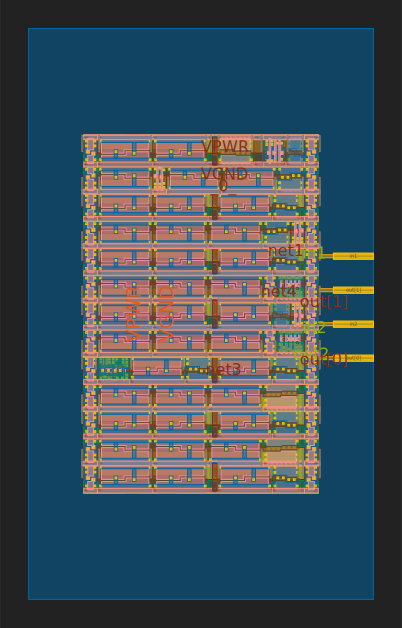

In [27]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('adder.svg')
IPython.display.SVG('adder.svg')

## Metrics

[Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)


In [28]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,__adder__adder
config,RUN_2023.11.07_10.14.50
flow_status,flow failed
total_runtime,0h1m1s0ms
routed_runtime,0h0m40s0ms
(Cell/mm^2)/Core_Util,7104.290992
DIEAREA_mm^2,0.001971
CellPer_mm^2,3552.145496
OpenDP_Util,-1
